# Training model

In [1]:
import os
import sys

if not os.path.exists('/kaggle/working/efficient-kan'):
    !git clone https://github.com/Blealtan/efficient-kan

if '/kaggle/working/efficient-kan/src' not in sys.path:
    sys.path.append('/kaggle/working/efficient-kan/src')
    
!pip install gdown

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import gc
from tqdm import tqdm

from efficient_kan import KANLinear
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

Cloning into 'efficient-kan'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 90 (delta 22), reused 14 (delta 14), pack-reused 61 (from 1)
Receiving objects: 100% (90/90), 33.26 KiB | 8.31 MiB/s, done.
Resolving deltas: 100% (33/33), done.


* Project folder: https://drive.google.com/drive/folders/16zlL06sykfj-6ZBVwEIyyTyojRreUuS9?usp=sharing
* You should download train_dataset, test_dataset and put it in Kaggle/Colab because of GGDrive limited bandwidth
* Remember to change the file address

In [2]:
def remove_stopwords(text, stop_words):
    words = text.split(' ')
    
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_words)

class NewsDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

        self.X_cleaned = [remove_stopwords(content, stop_words) for content in tqdm(X)]

    
    def tokenize(self, tokenizer):
        self.tokenized_X = tokenizer(self.X_cleaned,
                                    padding='max_length',
                                    truncation=True,
                                    max_length=8000,
                                    return_tensors="pt"
                                )

    def __getitem__(self, idx):
        return self.tokenized_X['input_ids'][idx], self.tokenized_X['attention_mask'][idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)
    
!gdown --id 1v0N1cN8JUk2Z3leMFuLZWW3GBi-PCXIa
!gdown --id 1bw2jQgBXt3vKSGGGj0tA1Uny4xSL4wfP
    
train_dataset = torch.load('/kaggle/working/train_dataset.pth')
test_dataset = torch.load('/kaggle/working/test_dataset.pth')

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1v0N1cN8JUk2Z3leMFuLZWW3GBi-PCXIa
From (redirected): https://drive.google.com/uc?id=1v0N1cN8JUk2Z3leMFuLZWW3GBi-PCXIa&confirm=t&uuid=ca7a4016-47bb-41d7-aea9-aaeb3cb4aac2
To: /kaggle/working/train_dataset.pth
100%|██████████████████████████████████████| 1.85G/1.85G [00:49<00:00, 37.4MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bw2jQgBXt3vKSGGGj0tA1Uny4xSL4wfP
From (redirected): https://drive.google.com/uc?id=1bw2jQgBXt3vKSGGGj0tA1Uny4xSL4wfP&confirm=t&uuid=711316e5-4

/tmp/ipykernel_23/671465413.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('/kaggle/working/train_dataset.pth')
/tmp/ipykernel_23/671465413.

In [3]:
print(train_dataset.tokenized_X['input_ids'].shape)
print(test_dataset.tokenized_X['input_ids'].shape)
print(set(train_dataset.y))

torch.Size([9307, 8000])
torch.Size([6206, 8000])
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [4]:
num_classes = 12
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Models

## 1D CNN

In [5]:
class Block1(nn.Module):
    def __init__(self, in_channel, out_channel, seq_len):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv1d(in_channel, out_channel, 5, stride=1, dilation=2, padding=4),
            nn.LayerNorm([out_channel, seq_len]),
            nn.SiLU(),
            nn.Dropout(0.5)
        )
        
    def forward(self, x):
        return self.backbone(x)

# 1D CNN
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        st = 32
        
        self.input_embedding = nn.Embedding(64000, st)
        
        self.backbone = nn.Sequential(
            Block1(st, 2*st, 8000),
            nn.AvgPool1d(2),
            Block1(2*st, 4*st, 4000),
            nn.AvgPool1d(2),
            Block1(4*st, 8*st, 2000),
            nn.AvgPool1d(2),
            Block1(8*st, 8*st, 1000),
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.classifier = KANLinear(8*st, num_classes)
        
    def forward(self, x):
        x = self.input_embedding(x)
        if (x.shape[0] != 1):
            x = x.squeeze()
        x = x.transpose(1, 2)
        x = self.backbone(x).squeeze()
        x = self.classifier(x)
        return x
    
lr = 0.005
wd = 0.01

# 1D CNN
model1 = Model1()
optimizer1 = optim.AdamW(model1.parameters(), lr=lr, weight_decay=wd)
criterion1 = nn.CrossEntropyLoss()

## BiLSTM

In [6]:
# Bi-LSTM
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        st = 32
        
        self.input_embedding = nn.Embedding(64000, st)
        
        # Reduce sequence length from 8000 to 1000
        self.conv = nn.Sequential(
            nn.Conv1d(st, st*2, 5, stride=2, padding=2),
            nn.LayerNorm([st*2, 4000]),
            nn.SiLU(),
            nn.AvgPool1d(8, stride=4, padding=2),
            nn.Dropout(0.5)
        )
        
        self.hidden_size = st*4
        self.num_layers = 1
        self.backbone = nn.LSTM(st*2, self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        
        self.classifier = KANLinear(self.hidden_size*2, num_classes)
        
    def forward(self, x):        
        x = self.input_embedding(x)
        if (x.shape[0] != 1):
            x = x.squeeze()
        
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        output, _ = self.backbone(x, (h0, c0))
            
        output = self.classifier(output[:, -1, :])
        return output
    
lr = 0.005
wd = 0.01

# BiLSTM
model2 = Model2()
optimizer2 = optim.AdamW(model2.parameters(), lr=lr, weight_decay=wd)
criterion2 = nn.CrossEntropyLoss()

## BiGRU

In [7]:
# Bi-GRU
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        st = 32
        
        self.input_embedding = nn.Embedding(64000, st)
        
        # Reduce sequence length from 8000 to 1000
        self.conv = nn.Sequential(
            nn.Conv1d(st, st*2, 5, stride=2, padding=2),
            nn.LayerNorm([st*2, 4000]),
            nn.SiLU(),
            nn.AvgPool1d(8, stride=4, padding=2),
            nn.Dropout(0.5)
        )
        
        self.hidden_size = st*4
        self.num_layers = 1
        self.backbone = nn.GRU(st*2, self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        
        self.classifier = KANLinear(self.hidden_size*2, num_classes)
        
    def forward(self, x):        
        x = self.input_embedding(x)
        if (x.shape[0] != 1):
            x = x.squeeze()
        
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        output, _ = self.backbone(x, h0)
            
        output = self.classifier(output[:, -1, :])
        return output
    
lr = 0.005
wd = 0.01

# BiGRU
model3 = Model3()
optimizer3 = optim.AdamW(model3.parameters(), lr=lr, weight_decay=wd)
criterion3 = nn.CrossEntropyLoss()

## MiniBERT

In [8]:
# Kernel function
class Phi(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return F.elu(x) + 1

class AttentionLayer(nn.Module): # Linear Attention using Kernel
    def __init__(self, d_model=512, num_heads=8):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.W_query = nn.Linear(d_model, d_model)
        self.W_key = nn.Linear(d_model, d_model)
        self.W_value = nn.Linear(d_model, d_model)
        
        self.phi = Phi()
        
        self.out_proj = KANLinear(d_model, d_model)

    def forward(self, x):
        bs, seq_len, d_model = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Unroll last dim: (bs, seq_len, d_model) -> (bs, num_tokens, seq_len, num_head, head_dim)
        keys = keys.view(bs, seq_len, self.num_heads, self.head_dim)
        values = values.view(bs, seq_len, self.num_heads, self.head_dim)
        queries = queries.view(bs, seq_len, self.num_heads, self.head_dim)

        # Transpose: (bs, seq_len, num_heads, head_dim) -> (bs, num_heads, seq_len, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_weights = self.phi(keys.transpose(-1, -2)) @ values
        attn_weights = self.phi(queries) @ attn_weights

        # Combine heads, where self.d_model = self.num_heads * self.head_dim
        attn_weights = attn_weights.reshape(bs, seq_len, self.d_model)
        out = self.out_proj(attn_weights)

        return out
    
class EncoderLayer(nn.Module): # Pre-layernorm
    def __init__(self, d_model=512, num_heads=8, dropout=0.2):
        super().__init__()
        
        self.attention = AttentionLayer(d_model, num_heads)
        self.ff = KANLinear(d_model, d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        tmp = self.ln1(x)
        tmp = self.attention(tmp)
        tmp = self.dropout(tmp)
        x = x + tmp
        
        tmp = self.ln2(x)
        tmp = self.ff(tmp)
        tmp = self.dropout(tmp)
        x = x + tmp
        return x
    
# MiniBERT
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        st = 32
        
        self.input_embedding = nn.Embedding(64000, st)
        
        # Reduce sequence length from 8000 to 1000
        self.conv = nn.Sequential(
            nn.Conv1d(st, st*2, 5, stride=2, padding=2),
            nn.LayerNorm([st*2, 4000]),
            nn.SiLU(),
            nn.AvgPool1d(8, stride=4, padding=2)
        )
        
        self.upsampling = nn.Sequential(
            KANLinear(st*2, st*4),
            nn.Dropout(0.4)
        )
        
        self.pos_emb = nn.Embedding(1000, st*4)
        position = torch.arange(0, 1000).unsqueeze(0)
        self.register_buffer('position', position)
        
        self.backbone = EncoderLayer(d_model=st*4, num_heads=4, dropout=0.4)
        self.lastnorm = nn.LayerNorm(st*4)
        
        self.classifier = KANLinear(st*4, num_classes)
        
    def forward(self, x):        
        x = self.input_embedding(x)
        if (x.shape[0] != 1):
            x = x.squeeze()
        
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x = self.upsampling(x)
        
        x = x + self.pos_emb(self.position)
        
        output = self.backbone(x)
        output = self.lastnorm(output)
            
        output = self.classifier(output[:, 0, :])
        return output
    
lr = 0.005
wd = 0.01

# MiniBERT
model4 = Model4()
optimizer4 = optim.AdamW(model4.parameters(), lr=lr, weight_decay=wd)
criterion4 = nn.CrossEntropyLoss()

## Training

In [9]:
def calculate_loss_batch(model, X_batch, y_batch, criterion):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device) - 1

    y_pred = model(X_batch)

    loss = criterion(y_pred, y_batch)
    return loss

def calculate_acc_batch(model, X_batch, y_batch):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device) - 1

    y_pred = model(X_batch)

    y_pred = torch.argmax(y_pred, dim=1)
    acc = accuracy_score(y_pred.cpu(), y_batch.cpu())
    return acc

In [10]:
def eval_model(model, model_name, test_dataloader):
    model = model.to(device)
    model.eval()
    
    y_pred = []
    y_truth = []
    
    for X_batch, _, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device) - 1

        pred = model(X_batch)
        pred = torch.argmax(pred, dim=1)

        y_batch = y_batch.cpu()
        pred = pred.cpu()
        
        y_pred.append(pred)
        y_truth.append(y_batch)
        
    y_pred = torch.cat(y_pred)
    y_truth = torch.cat(y_truth)
    
    acc = accuracy_score(y_truth, y_pred)
    f1 = f1_score(y_truth, y_pred, average='weighted')
    cm = confusion_matrix(y_truth, y_pred)
    
    print(f'Accuracy: {acc}, F1: {f1}')
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix of {model_name} model')

    # Save the figure
    plt.savefig(f'{model_name}_confusion_matrix.png')

    # Show the plot
    plt.show()

In [11]:
def train_model(model, model_name, train_dataloader, test_dataloader, optimizer, criterion, epochs=20):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    
    model = model.to(device)
    
    best_loss = 500
    best_acc = 0
    best_ep = -1

    for ep in range(epochs):
        model.train()

        train_loss = 0.0
        train_acc = 0.0

        for X_batch, _, y_batch in train_dataloader:            
            optimizer.zero_grad()
            loss = calculate_loss_batch(model, X_batch, y_batch, criterion)
            loss.backward()
            
            if model_name in ('bi_lstm', 'bi_gru'):
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)
                
            optimizer.step()

            train_loss += loss.cpu().item()

            acc = calculate_acc_batch(model, X_batch, y_batch)
            train_acc += acc

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        model.eval()

        test_loss = 0.0
        test_acc = 0.0

        for X_batch, _, y_batch in test_dataloader:
            loss = calculate_loss_batch(model, X_batch, y_batch, criterion)
            test_loss += loss.item()

            acc = calculate_acc_batch(model, X_batch, y_batch)
            test_acc += acc
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        print(f'Epoch {ep + 1}/{epochs}: Train loss {train_loss}, Test loss {test_loss}, Train acc {train_acc}, Test acc {test_acc}')

        if test_acc >= best_acc:
            best_loss = test_loss
            best_acc = test_acc
            best_ep = ep
            torch.save(model.state_dict(), f'/kaggle/working/{model_name}_best_loss_weigth.pth')
            print(f'Saved epoch at {ep + 1}')
            
    print(f'Best epoch at {best_ep + 1}, Best acc: {best_acc}, Best loss: {best_loss}')
            
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [12]:
n_epochs = 50

Epoch 1/50: Train loss 2.367708766297118, Test loss 2.3225346766796306, Train acc 0.18191907661085743, Test acc 0.18110866311938809
Saved epoch at 1
Epoch 2/50: Train loss 1.9859741640417543, Test loss 1.7614495975455058, Train acc 0.2795614535768645, Test acc 0.32244554373129364
Saved epoch at 2
Epoch 3/50: Train loss 1.6477462126784128, Test loss 1.6741123924550323, Train acc 0.3896419964485033, Test acc 0.3958939557698703
Saved epoch at 3
Epoch 4/50: Train loss 1.4888905866505349, Test loss 1.6949344689084083, Train acc 0.45485714738711314, Test acc 0.3952756069171932
Epoch 5/50: Train loss 1.3671233907137832, Test loss 1.6992435467611884, Train acc 0.5079274479959411, Test acc 0.40556410043232455
Saved epoch at 5
Epoch 6/50: Train loss 1.2509542617895832, Test loss 1.7556429314859134, Train acc 0.5592814561136479, Test acc 0.4128076155636847
Saved epoch at 6
Epoch 7/50: Train loss 1.1441575827663892, Test loss 1.7527732713935302, Train acc 0.6029458396752917, Test acc 0.43310400731

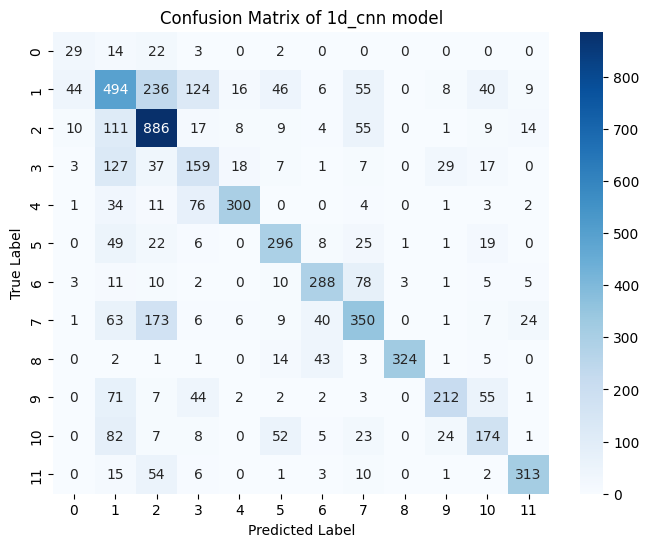

In [13]:
train_loss_list1, test_loss_list1, train_acc_list1, test_acc_list1 = train_model(model1, '1d_cnn', train_dataloader, test_dataloader, optimizer1, criterion1, epochs=n_epochs)

data = {
    'train_loss': train_loss_list1,
    'test_loss': test_loss_list1,
    'train_acc': train_acc_list1,
    'test_acc': test_acc_list1
}

torch.save(data, 'result_1d_cnn.pth')

eval_model(model1, '1d_cnn', test_dataloader)

model1 = model1.cpu()

Epoch 1/50: Train loss 2.3627499456275, Test loss 2.3509526768910516, Train acc 0.17902952181633688, Test acc 0.18110866311938809
Saved epoch at 1
Epoch 2/50: Train loss 2.3544733410012233, Test loss 2.339545657954265, Train acc 0.1811025494672755, Test acc 0.18110866311938809
Saved epoch at 2
Epoch 3/50: Train loss 2.3544633421179366, Test loss 2.3399475186141494, Train acc 0.1816376522070015, Test acc 0.18110866311938809
Saved epoch at 3
Epoch 4/50: Train loss 2.3544893362750745, Test loss 2.3388924500376906, Train acc 0.17810597412480975, Test acc 0.18110866311938809
Saved epoch at 4
Epoch 5/50: Train loss 2.353283945828268, Test loss 2.3404723688499214, Train acc 0.18006009005580925, Test acc 0.1737144579314932
Epoch 6/50: Train loss 2.3522691530724096, Test loss 2.338148441511331, Train acc 0.1791087962962963, Test acc 0.18110866311938809
Saved epoch at 6
Epoch 7/50: Train loss 2.352369434212985, Test loss 2.339173053957752, Train acc 0.1791087962962963, Test acc 0.181108663119388

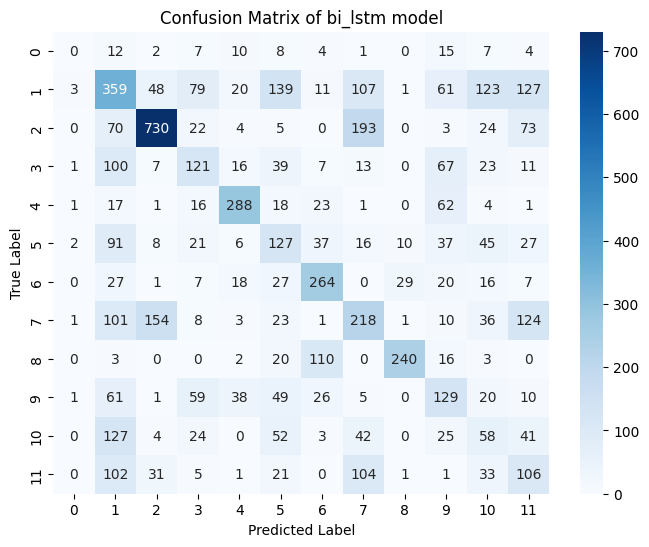

In [14]:
train_loss_list2, test_loss_list2, train_acc_list2, test_acc_list2 = train_model(model2, 'bi_lstm', train_dataloader, test_dataloader, optimizer2, criterion2, epochs=n_epochs)

data = {
    'train_loss': train_loss_list2,
    'test_loss': test_loss_list2,
    'train_acc': train_acc_list2,
    'test_acc': test_acc_list2
}

torch.save(data, 'result_bi_lstm.pth')

eval_model(model2, 'bi_lstm', test_dataloader)

model2 = model2.cpu()

Epoch 1/50: Train loss 2.3667065003146863, Test loss 2.3524094807732965, Train acc 0.17977866565195333, Test acc 0.18110866311938809
Saved epoch at 1
Epoch 2/50: Train loss 2.3564022436533887, Test loss 2.3471044682964837, Train acc 0.18235904997463218, Test acc 0.18110866311938809
Saved epoch at 2
Epoch 3/50: Train loss 2.3530066797178084, Test loss 2.3553991612699843, Train acc 0.18080923389142567, Test acc 0.18110866311938809
Saved epoch at 3
Epoch 4/50: Train loss 2.0118795200569988, Test loss 1.8541815956843268, Train acc 0.2762794901065449, Test acc 0.3024297472564017
Saved epoch at 4
Epoch 5/50: Train loss 1.7743864059448242, Test loss 1.71324640205226, Train acc 0.35210553018772195, Test acc 0.3593282341203857
Saved epoch at 5
Epoch 6/50: Train loss 1.6171745331320044, Test loss 1.620460038332595, Train acc 0.40633720192795536, Test acc 0.39282299634186896
Saved epoch at 6
Epoch 7/50: Train loss 1.4488178213981733, Test loss 1.510590452508828, Train acc 0.47226185946220195, Tes

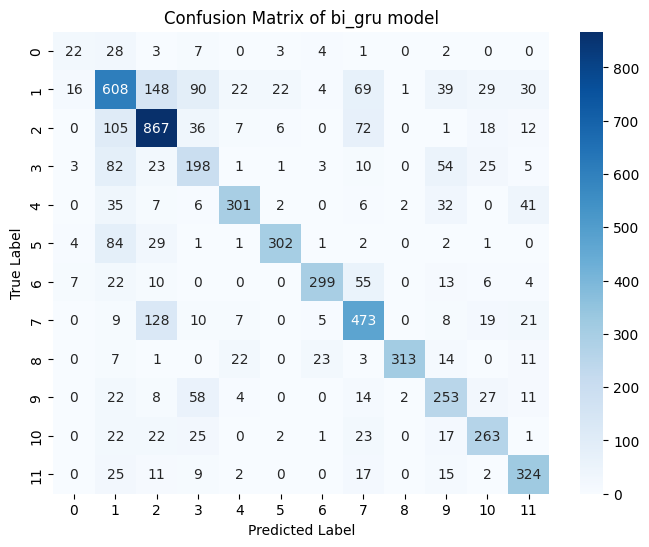

In [15]:
train_loss_list3, test_loss_list3, train_acc_list3, test_acc_list3 = train_model(model3, 'bi_gru', train_dataloader, test_dataloader, optimizer3, criterion3, epochs=n_epochs)

data = {
    'train_loss': train_loss_list3,
    'test_loss': test_loss_list3,
    'train_acc': train_acc_list3,
    'test_acc': test_acc_list3
}

torch.save(data, 'result_bi_gru.pth')

eval_model(model3, 'bi_gru', test_dataloader)

model3 = model3.cpu()

Epoch 1/50: Train loss 2.373951358337925, Test loss 2.3577473999298726, Train acc 0.18012747336377474, Test acc 0.1737144579314932
Saved epoch at 1
Epoch 2/50: Train loss 2.2606732559530704, Test loss 2.019161011754852, Train acc 0.20154347412480975, Test acc 0.248799675756568
Saved epoch at 2
Epoch 3/50: Train loss 1.8089552039969456, Test loss 1.8243375770824473, Train acc 0.3238917427701674, Test acc 0.35191844030595276
Saved epoch at 3
Epoch 4/50: Train loss 1.537360576734151, Test loss 1.765690798611985, Train acc 0.4367310375443937, Test acc 0.3876891420019954
Saved epoch at 4
Epoch 5/50: Train loss 1.3648854820695642, Test loss 1.8447044448754222, Train acc 0.5087122653475393, Test acc 0.4057459677419355
Saved epoch at 5
Epoch 6/50: Train loss 1.215668410471041, Test loss 1.8994265819333263, Train acc 0.5743713533739219, Test acc 0.4484640006651147
Saved epoch at 6
Epoch 7/50: Train loss 1.084486040350509, Test loss 1.9298024914928318, Train acc 0.6371924150177575, Test acc 0.46

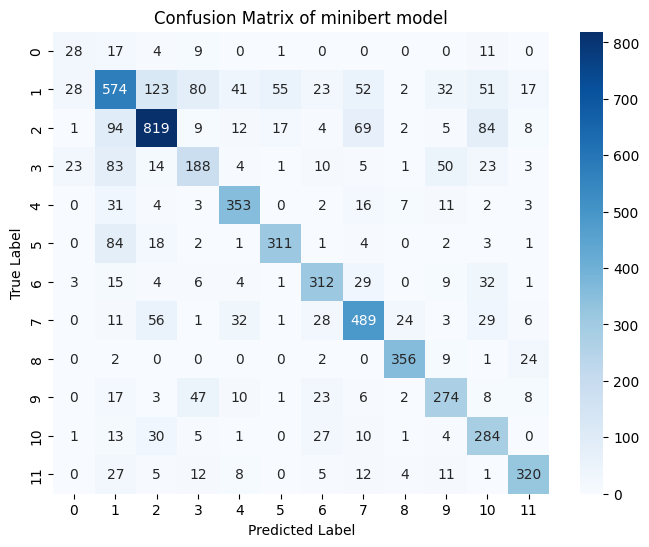

In [16]:
train_loss_list4, test_loss_list4, train_acc_list4, test_acc_list4 = train_model(model4, 'minibert', train_dataloader, test_dataloader, optimizer4, criterion4, epochs=n_epochs)

data = {
    'train_loss': train_loss_list4,
    'test_loss': test_loss_list4,
    'train_acc': train_acc_list4,
    'test_acc': test_acc_list4
}

torch.save(data, 'result_bi_minibert.pth')

eval_model(model4, 'minibert', test_dataloader)

model4 = model4.cpu()

# Visualize

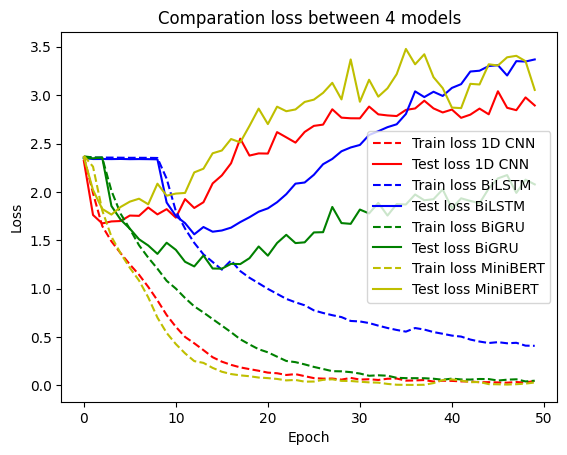

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(train_loss_list1, 'r--', label='Train loss 1D CNN')
plt.plot(test_loss_list1, 'r-', label='Test loss 1D CNN')
plt.plot(train_loss_list2, 'b--', label='Train loss BiLSTM')
plt.plot(test_loss_list2, 'b-', label='Test loss BiLSTM')
plt.plot(train_loss_list3, 'g--', label='Train loss BiGRU')
plt.plot(test_loss_list3, 'g-', label='Test loss BiGRU')
plt.plot(train_loss_list4, 'y--', label='Train loss MiniBERT')
plt.plot(test_loss_list4, 'y-', label='Test loss MiniBERT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparation loss between 4 models')
plt.show()

plt.savefig('comparation_loss_plot.png')

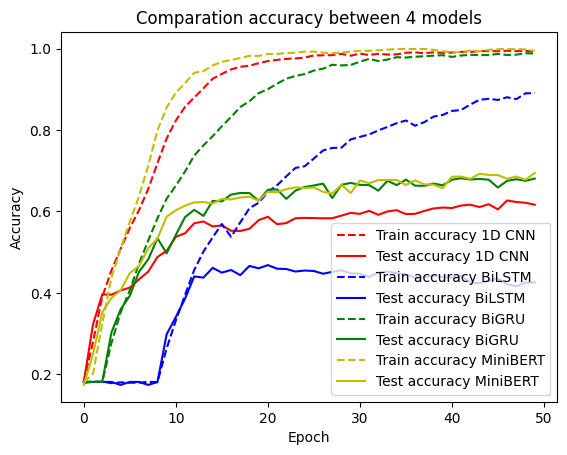

<Figure size 640x480 with 0 Axes>

In [18]:
plt.plot(train_acc_list1, 'r--', label='Train accuracy 1D CNN')
plt.plot(test_acc_list1, 'r-', label='Test accuracy 1D CNN')
plt.plot(train_acc_list2, 'b--', label='Train accuracy BiLSTM')
plt.plot(test_acc_list2, 'b-', label='Test accuracy BiLSTM')
plt.plot(train_acc_list3, 'g--', label='Train accuracy BiGRU')
plt.plot(test_acc_list3, 'g-', label='Test accuracy BiGRU')
plt.plot(train_acc_list4, 'y--', label='Train accuracy MiniBERT')
plt.plot(test_acc_list4, 'y-', label='Test accuracy MiniBERT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparation accuracy between 4 models')
plt.show()

plt.savefig('comparation_loss_plot.png')